In [30]:
import tensorflow as tf

tf.__version__

'2.8.2'

In [29]:
from tensorflow.keras import datasets, layers, models #Tensorflow에 있는 Keras 함수들 호출하기

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import PIL

sns.set(style='darkgrid')

In [3]:
pip install -q tf-nightly

     |████████████████████████████████| 582.2 MB 20 kB/s 
     |████████████████████████████████| 1.7 MB 58.6 MB/s 
     |████████████████████████████████| 439 kB 66.2 MB/s 
     |████████████████████████████████| 5.9 MB 58.5 MB/s 


In [4]:
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/

SyntaxError: ignored

In [4]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 1s 0us/step


In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


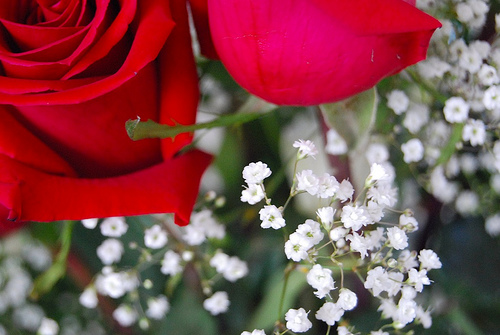

In [6]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

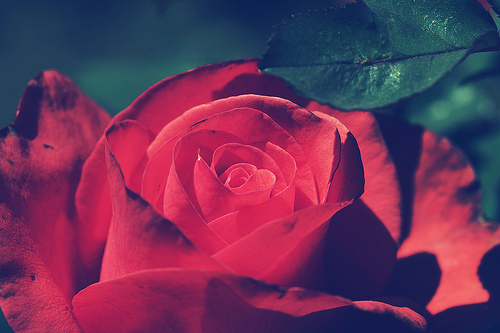

In [7]:
PIL.Image.open(str(roses[1]))

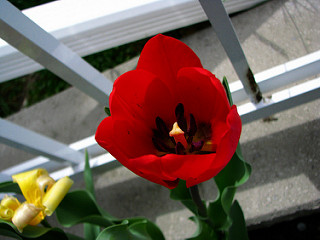

In [8]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

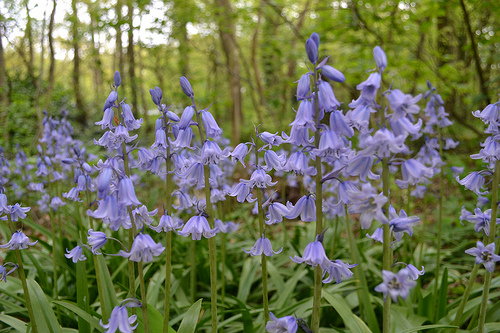

In [9]:
PIL.Image.open(str(tulips[1]))

# 테이터 셋 만들기

In [10]:
bacth_size=32
img_height=180
img_width=180

In [11]:
train_ds=tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height,img_width),
    batch_size=bacth_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [12]:
val_ds=tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height,img_width),
    batch_size=bacth_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [13]:
class_names=train_ds.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [14]:
#시각화

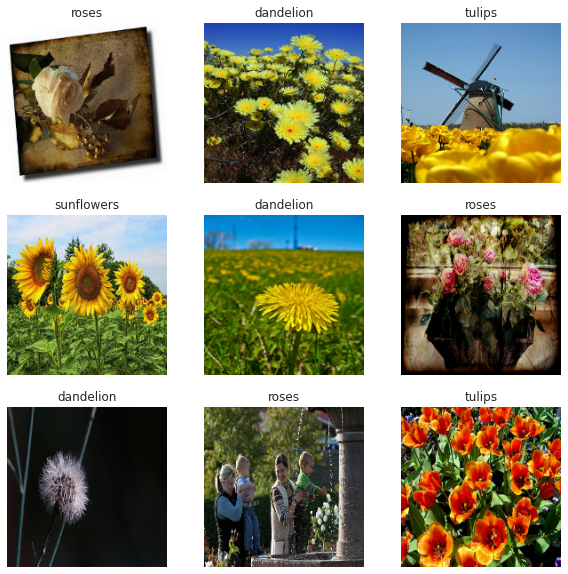

In [15]:
plt.figure(figsize=(10,10))

for images,labels in train_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))#.numpy().astype("uint8") 색(컬러)과 관련된듯?
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [16]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [17]:
#성능을 높이도록 데이터세트 구성하기

In [18]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
#데이터표준화하기

In [20]:
normalization_layer=layers.experimental.preprocessing.Rescaling(1./255)

In [21]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.89825714


In [22]:
from keras.engine.sequential import Sequential
model=Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height,img_width,3)),
    layers.Conv2D(16,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(5,activation='softmax')
])

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics='accuracy')

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [25]:
history=model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  


90/92 [============================>.] - ETA: 0s - loss: 1.3234 - accuracy: 0.4359

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
92/92 [==============================] - 18s 50ms/step - loss: 1.3182 - accuracy: 0.4380 - val_loss: 1.1221 - val_accuracy: 0.5490
Epoch 2/10
92/92 [==============================] - 2s 24ms/step - loss: 1.0227 - accuracy: 0.5892 - val_loss: 0.9572 - val_accuracy: 0.6240
Epoch 3/10
92/92 [==============================] - 2s 24ms/step - loss: 0.7832 - accuracy: 0.7101 - val_loss: 0.9689 - val_accuracy: 0.6471
Epoch 4/10
92/92 [==============================] - 2s 23ms/step - loss: 0.5950 - accuracy: 0.7844 - val_loss: 0.8877 - val_accuracy: 0.6689
Epoch 5/10
92/92 [==============================] - 2s 23ms/step - loss: 0.3719 - accuracy: 0.8736 - va

In [26]:
#훈련결과 시각화하기

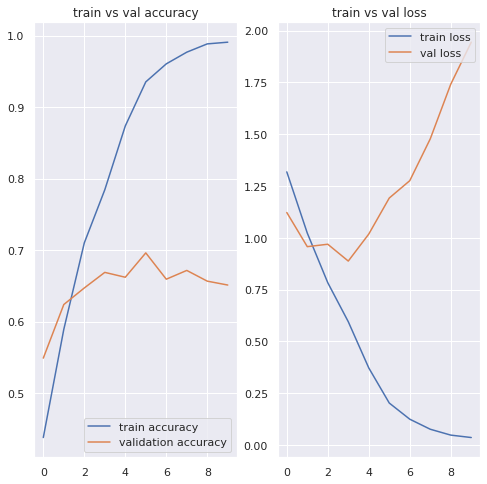

In [49]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(10)

#accuracy 확인
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='train accuracy')
plt.plot(epochs_range,val_acc,label='validation accuracy')
plt.legend(loc='lower right')
plt.title('train vs val accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='train loss')
plt.plot(epochs_range,val_loss,label='val loss')
plt.legend(loc='upper right')
plt.title('train vs val loss')

plt.show()
#과적합(overfitting)이 일어남
#훈련 과정에서 과대적합을 막는 여러 가지 방법들이 있습니다. 이 튜토리얼에서는 데이터 증강을 사용하고 모델에 드롭아웃을 추가합니다.

# 데이터 증강하기

In [ ]:
#overfitting은 일반적으로 훈련 예제가 적을 때 발생합니다. 
# 데이터 증강은 증강한 다음 믿을 수 있는 이미지를 생성하는 임의 변환을 사용하는 방법으로 기존 예제에서 추가 훈련 데이터를 생성하는 접근법을 취합니다. 
#러면 모델이 데이터의 더 많은 측면을 파악하게 되므로 일반화가 더 쉬워집니다.

#여기서는 실험적인 Keras 전처리 레이어를 사용하여 데이터 증강을 구현합니다. 이들 레이어는 다른 레이어와 마찬가지로 모델 내에 포함될 수 있으며, GPU에서 실행됩니다.

In [34]:
data_augmentation =Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal',
                                                 input_shape=(img_height,img_width,3)
                                                 ),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomRotation(0.1)
])

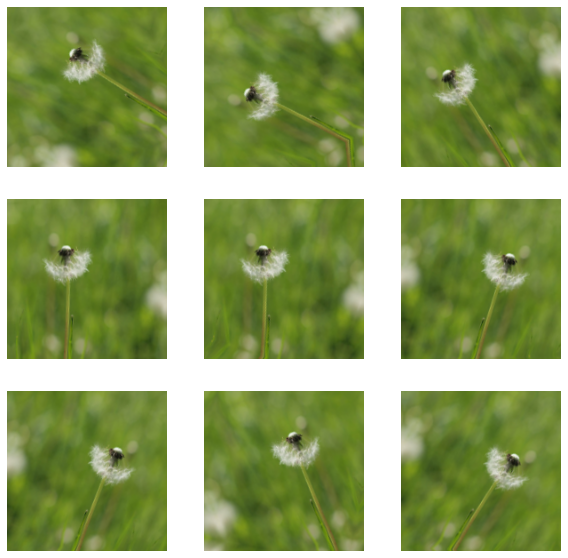

In [39]:
#시각화 해보기

plt.figure(figsize=(10,10))

for images,_ in train_ds.take(1):
  for i in range(9):
    augmented_images =data_augmentation(images)
    ax=plt.subplot(3,3,i+1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")
plt.show()
#즉 데이터증강은 말그대로 한개의 데이터를 여러방향으로 만들어준다. 데이터가 늘어난다.

# 드롭아웃

In [ ]:
#과대적합을 줄이는 또 다른 기술은 정규화의 한 형태인 드롭아웃을 네트워크에 도입하는 것입니다.


#드롭아웃을 레이어에 적용하면, 훈련 프로세스 중에 레이어에서 여러 출력 단위가 무작위로 드롭아웃됩니다(활성화를 0으로 설정).
#드롭아웃은 0.1, 0.2, 0.4 등의 형식으로 소수를 입력 값으로 사용합니다
#이는 적용된 레이어에서 출력 단위의 10%, 20% 또는 40%를 임의로 제거하는 것을 의미합니다.


#layers.Dropout을 사용하여 새로운 신경망을 생성한 다음, 증강 이미지를 사용하여 훈련해 보겠습니다.

In [61]:
from keras.engine.sequential import Sequential
model=Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(16,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(5,activation='softmax')
])

In [62]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics='accuracy'
)

In [56]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 45, 45, 64)       

In [63]:
history=model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15
)

Epoch 1/15


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
91/92 [============================>.] - ETA: 0s - loss: 1.4308 - accuracy: 0.4036

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
92/92 [==============================] - 3s 28ms/step - loss: 1.4283 - accuracy: 0.4057 - val_loss: 1.1297 - val_accuracy: 0.5313
Epoch 2/15
92/92 [==============================] - 2s 27ms/step - loss: 1.0932 - accuracy: 0.5705 - val_loss: 1.0217 - val_accuracy: 0.6063
Epoch 3/15
92/92 [==============================] - 2s 26ms/step - loss: 0.9777 - accuracy: 0.6213 - val_loss: 1.0288 - val_accuracy: 0.5967
Epoch 4/15
92/92 [==============================] - 2s 26ms/step - loss: 0.9093 - accuracy: 0.6522 - val_loss: 0.9269 - val_accuracy: 0.6594
Epoch 5/15
92/92 [==============================] - 2s 26ms/step - loss: 0.8503 - accuracy: 0.6785 - val

In [64]:
#훈련 결과 시각화

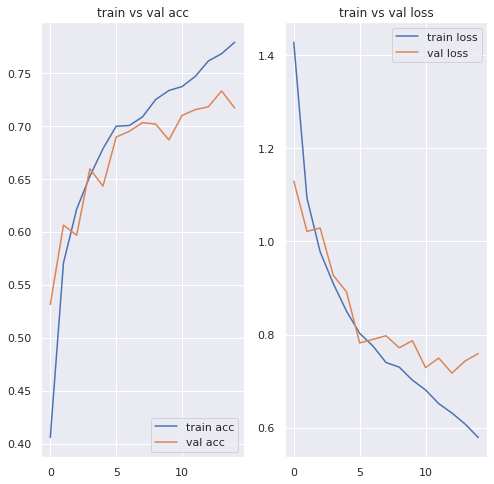

In [66]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='train acc')
plt.plot(epochs_range,val_acc,label='val acc')
plt.legend(loc='lower right')
plt.title('train vs val acc')

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='train loss')
plt.plot(epochs_range,val_loss,label='val loss')
plt.legend(loc='upper right')
plt.title('train vs val loss')

plt.show()

# 새로운 데이터 예측

In [70]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
This image most likely belongs to sunflowers with a 28.61 percent confidence.
